In [ ]:
from pyspark.sql import SparkSession


In [ ]:
spark = SparkSession.builder \
    .appName("YelpDataAnalysis") \
    .getOrCreate()

24/11/19 20:56:22 WARN Utils: Your hostname, yelp resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/11/19 20:56:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/11/19 20:56:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [ ]:
business_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_business.json")
checkin_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_checkin.json")
review_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_review.json")
tip_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_tip.json")
user_df = spark.read.json("file:///home/dps/Documents/yelp_dataset/yelp_academic_dataset_user.json")

24/11/19 20:56:29 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
business_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/business")
checkin_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/checkin")
review_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/review")
tip_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/tip")
user_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/user")


In [ ]:
business_df.createOrReplaceTempView("businesses")
checkin_df.createOrReplaceTempView("checkins")
review_df.createOrReplaceTempView("reviews")
tip_df.createOrReplaceTempView("tips")
user_df.createOrReplaceTempView("users")

In [ ]:
arizona_businesses_df = spark.sql("SELECT * FROM businesses WHERE state = 'AZ'")
arizona_businesses_df.createOrReplaceTempView("arizona_businesses")

In [ ]:
arizona_businesses_df.write.mode("overwrite").parquet("file:///home/dps/Documents/yelp_parquet/arizona_businesses")

In [ ]:
# Query 1: Top 5 Cities in Arizona by Business Count
print("Query 1: Top 5 Cities in Arizona by Business Count")
spark.sql("""
    SELECT city, COUNT(business_id) AS business_count
    FROM arizona_businesses
    GROUP BY city
    ORDER BY business_count DESC
    LIMIT 5
""").show()

Query 1: Top 5 Cities in Arizona by Business Count


+------------+--------------+
|        city|business_count|
+------------+--------------+
|      Tucson|          9249|
|  Oro Valley|           286|
|      Marana|           102|
|Green Valley|            69|
|   Sahuarita|            69|
+------------+--------------+



In [ ]:
# Query 2: Average Ratings of Businesses by Category
print("Query 2: Average Ratings of Businesses by Category")
spark.sql("""
    SELECT categories, AVG(stars) AS avg_rating
    FROM arizona_businesses
    GROUP BY categories
    ORDER BY avg_rating DESC
    LIMIT 10
""").show(truncate=False)



Query 2: Average Ratings of Businesses by Category


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|categories                                                                                                                                                                                      |avg_rating|
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+
|Diagnostic Services, Diagnostic Imaging, Radiologists, Health & Medical, Doctors, Surgeons, Medical Centers                                                                                     |5.0       |
|Axe Throwing, Nightlife, Active Life, Team Building Activities, Amusement Parks, Sports Clubs, Event Planning & Services                                                       

In [ ]:
# Query 3: Top Zip Codes for Highly Rated Restaurants
print("Query 3: Top Zip Codes for Highly Rated Restaurants")
spark.sql("""
    SELECT b.postal_code, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS review_count
    FROM arizona_businesses b
    JOIN reviews r ON b.business_id = r.business_id
    WHERE b.categories LIKE '%Restaurants%' AND b.postal_code IS NOT NULL AND b.postal_code != ''
    GROUP BY b.postal_code
    ORDER BY avg_rating DESC, review_count DESC
    LIMIT 5
""").show()


Query 3: Top Zip Codes for Highly Rated Restaurants


+-----------+------------------+------------+
|postal_code|        avg_rating|review_count|
+-----------+------------------+------------+
|      85701|3.9611370682502947|       22901|
|      85716|3.8600715598104633|       20682|
|      85750| 3.839372514361467|        4526|
|      85719|3.8033874423929315|       34067|
|      85735|3.7880184331797233|         217|
+-----------+------------------+------------+



In [ ]:
# Query 4: Most Popular Cities for Highly Rated Restaurants
spark.sql("""
    SELECT b.city, COUNT(b.business_id) AS restaurant_count
    FROM arizona_businesses b
    WHERE b.categories LIKE '%Restaurants%' AND b.stars >= 4
    GROUP BY b.city
    ORDER BY restaurant_count DESC
    LIMIT 10
""").show()

+-------------+----------------+
|         city|restaurant_count|
+-------------+----------------+
|       Tucson|             986|
|   Oro Valley|              31|
|       Marana|              14|
|         Vail|               4|
| Green Valley|               4|
|    Sahuarita|               4|
|     Catalina|               3|
|       Tuscon|               2|
|Valencia West|               1|
|Picture Rocks|               1|
+-------------+----------------+



In [ ]:
# Query 5: Positive Review Analysis by Zip Code
print("Query 5: Positive Review Analysis by Zip Code")
spark.sql("""
    SELECT b.postal_code, COUNT(r.review_id) AS positive_review_count
    FROM arizona_businesses b
    JOIN reviews r ON b.business_id = r.business_id
    WHERE r.text LIKE '%excellent%' OR r.text LIKE '%great%'
    GROUP BY b.postal_code
    ORDER BY positive_review_count DESC
    LIMIT 5
""").show()

Query 5: Positive Review Analysis by Zip Code


+-----------+---------------------+
|postal_code|positive_review_count|
+-----------+---------------------+
|      85719|                14162|
|      85705|                11811|
|      85701|                10359|
|      85711|                 9598|
|      85704|                 9363|
+-----------+---------------------+



In [ ]:
pandas_df = arizona_businesses_df.toPandas()

In [ ]:
import matplotlib.pyplot as plt

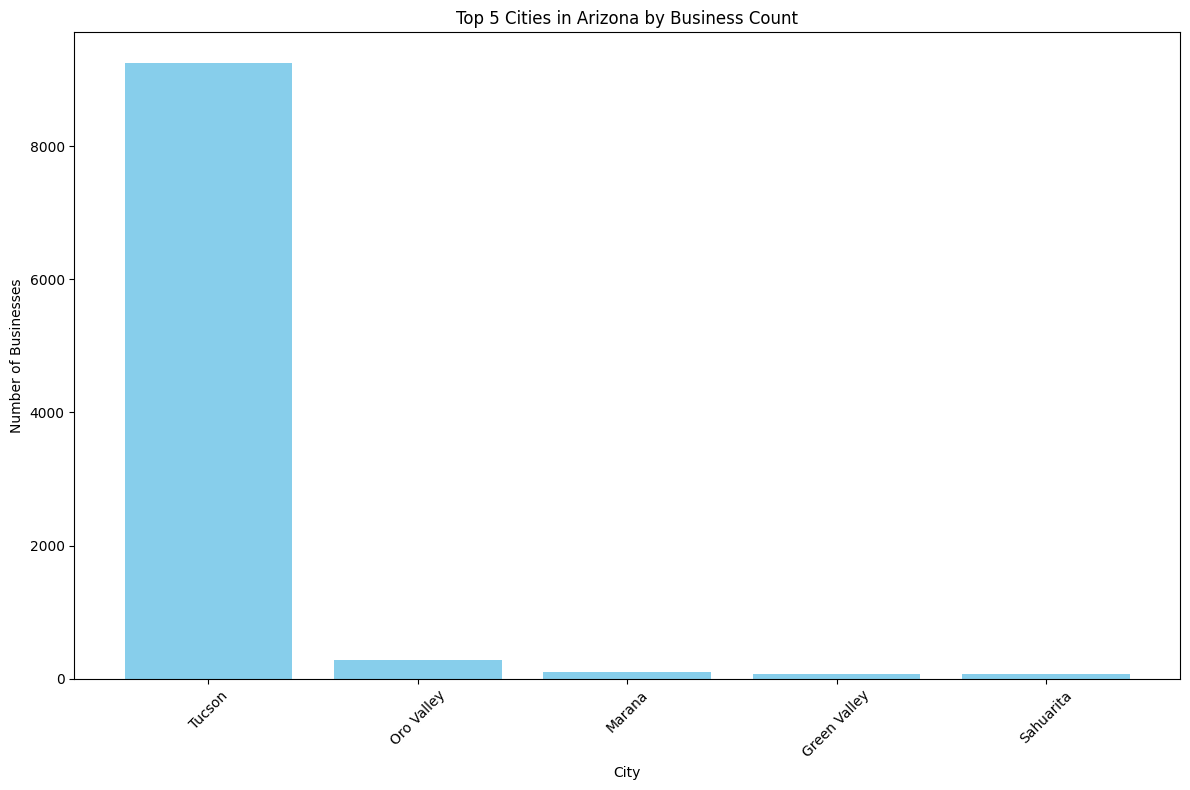

In [ ]:
# Visualisation for Query 1
top_cities_df = spark.sql("""
    SELECT city, COUNT(business_id) AS business_count
    FROM arizona_businesses
    GROUP BY city
    ORDER BY business_count DESC
    LIMIT 5
""").toPandas()

plt.figure(figsize=(12, 8))
plt.bar(top_cities_df['city'], top_cities_df['business_count'], color='skyblue')
plt.xlabel('City')
plt.ylabel('Number of Businesses')
plt.title('Top 5 Cities in Arizona by Business Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipykernel_2011/983393689.py:15: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


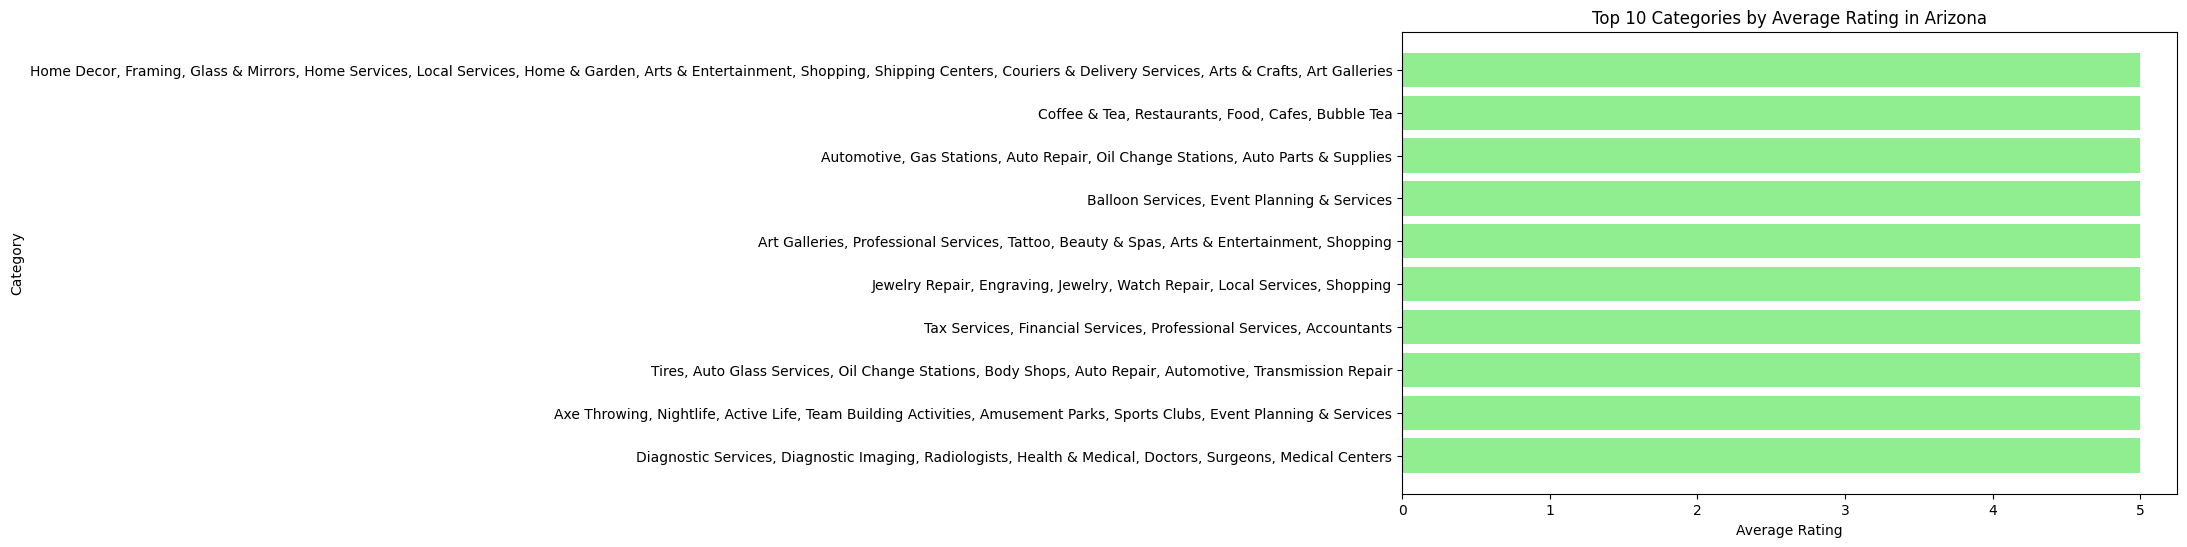

In [ ]:
# Visualisation for Query 2
avg_rating_df = spark.sql("""
    SELECT categories, AVG(stars) AS avg_rating
    FROM arizona_businesses
    GROUP BY categories
    ORDER BY avg_rating DESC
    LIMIT 10
""").toPandas()

plt.figure(figsize=(10, 6))
plt.barh(avg_rating_df['categories'], avg_rating_df['avg_rating'], color='lightgreen')
plt.xlabel('Average Rating')
plt.ylabel('Category')
plt.title('Top 10 Categories by Average Rating in Arizona')
plt.tight_layout()
plt.show()

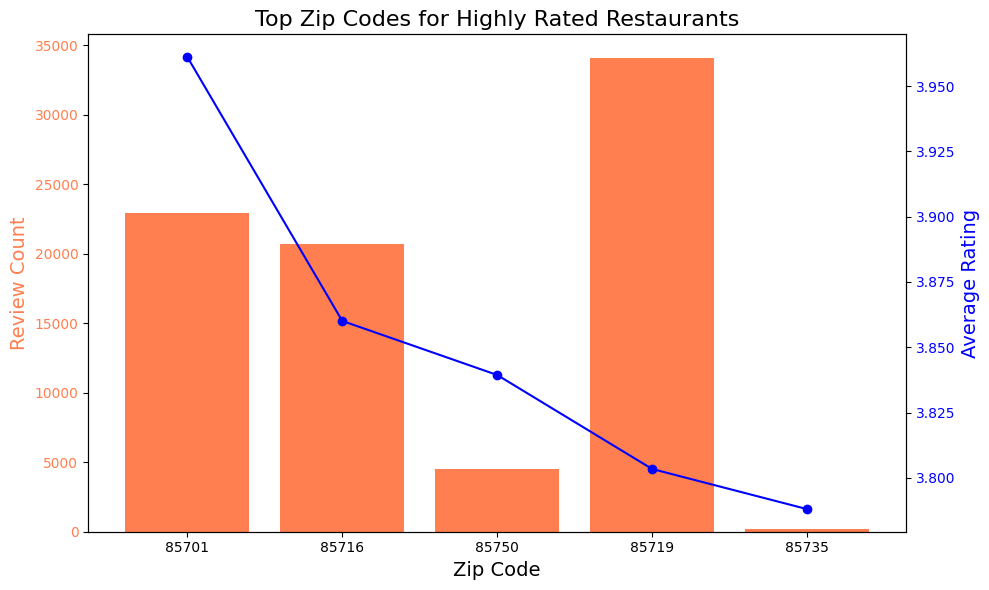

In [ ]:
# Visualisation for Query 3
top_zipcodes_df = spark.sql("""
    SELECT b.postal_code, AVG(r.stars) AS avg_rating, COUNT(r.review_id) AS review_count
    FROM arizona_businesses b
    JOIN reviews r ON b.business_id = r.business_id
    WHERE b.categories LIKE '%Restaurants%' AND b.postal_code IS NOT NULL AND b.postal_code != ''
    GROUP BY b.postal_code
    ORDER BY avg_rating DESC, review_count DESC
    LIMIT 5
""").toPandas()


fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart for Review Count
ax1.bar(top_zipcodes_df['postal_code'], top_zipcodes_df['review_count'], color='coral', label='Review Count')
ax1.set_xlabel('Zip Code', fontsize=14)
ax1.set_ylabel('Review Count', fontsize=14, color='coral')
ax1.tick_params(axis='y', labelcolor='coral')

# Line chart for Average Rating
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(top_zipcodes_df['postal_code'], top_zipcodes_df['avg_rating'], color='blue', marker='o', label='Average Rating')
ax2.set_ylabel('Average Rating', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Top Zip Codes for Highly Rated Restaurants', fontsize=16)

fig.tight_layout()
plt.show()


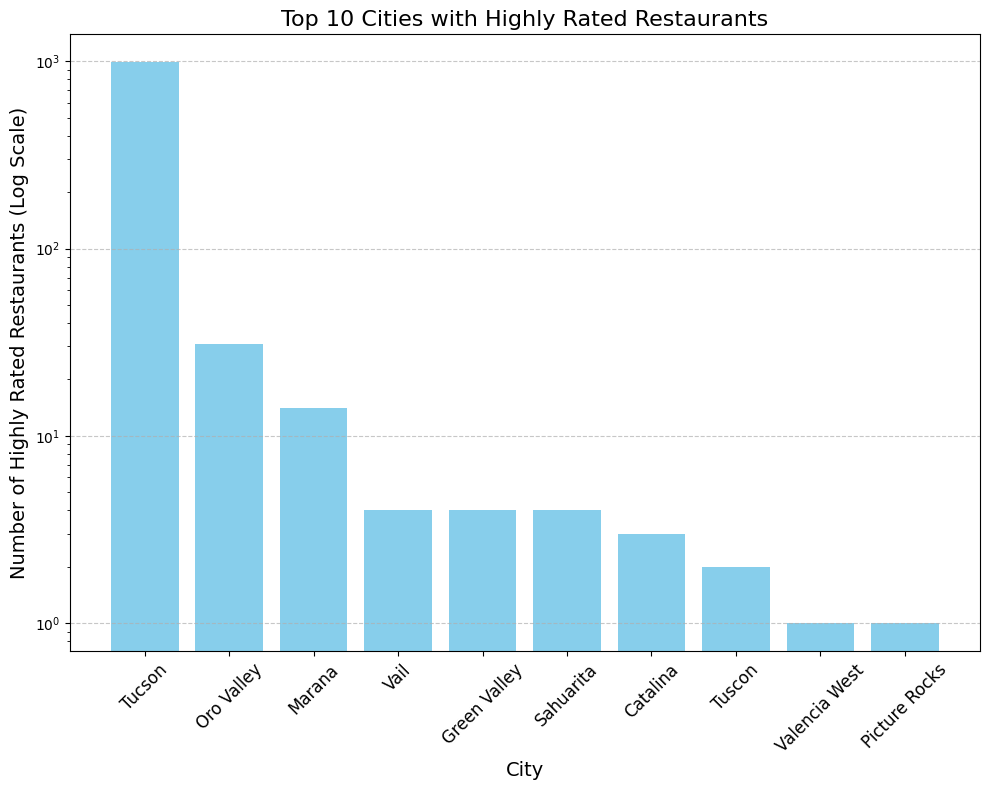

In [ ]:
# Visualisation for Query 4
popular_cities_df = spark.sql("""
    SELECT b.city, COUNT(b.business_id) AS restaurant_count
    FROM arizona_businesses b
    WHERE b.categories LIKE '%Restaurants%' AND b.stars >= 4
    GROUP BY b.city
    ORDER BY restaurant_count DESC
    LIMIT 10
""").toPandas()
plt.figure(figsize=(10, 8))
plt.bar(popular_cities_df['city'], popular_cities_df['restaurant_count'], color='skyblue')

# Set logarithmic scale for the Y-axis
plt.yscale('log')
plt.xlabel('City', fontsize=14)
plt.ylabel('Number of Highly Rated Restaurants (Log Scale)', fontsize=14)
plt.title('Top 10 Cities with Highly Rated Restaurants', fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

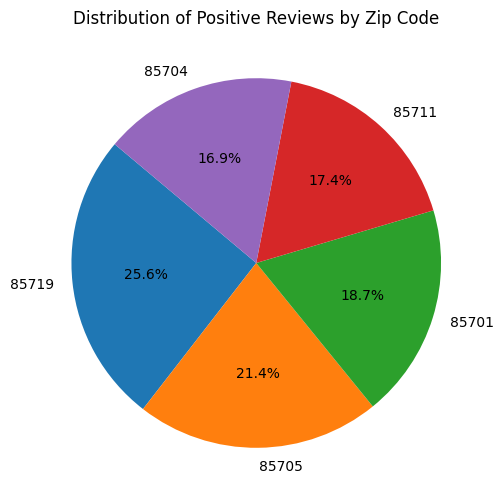

In [ ]:
# Visualisation for Query 5
positive_reviews_df = spark.sql("""
    SELECT b.postal_code, COUNT(r.review_id) AS positive_review_count
    FROM arizona_businesses b
    JOIN reviews r ON b.business_id = r.business_id
    WHERE r.text LIKE '%excellent%' OR r.text LIKE '%great%'
    GROUP BY b.postal_code
    ORDER BY positive_review_count DESC
    LIMIT 5
""").toPandas()


plt.figure(figsize=(6, 6))
plt.pie(positive_reviews_df['positive_review_count'], labels=positive_reviews_df['postal_code'], autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Positive Reviews by Zip Code')
plt.show()